In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
# import talib
import pickle
import pystan

import os, sys

sys.path.append(os.path.abspath(os.path.join('../src')))
from generative_models import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
# gpu setting and checking
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# print(tf.config.list_physical_devices('GPU'))

## Stan

In [8]:
stan_model = """
data {
  int<lower=0> N;                 
  real<lower=0> rt[N];    
  int<lower=0,upper=1> correct[N];
  int<lower=1,upper=4> context[N];
}

parameters {
  real<lower=0> v[4];
  real<lower=0> a; 
  real<lower=0> ndt;
}

model {
  // Priors
  v ~ gamma(2.5, 1.5);
  a ~ gamma(4.0, 3.0);
  ndt ~ gamma(1.5, 5.0);
  
  for (n in 1:N) {
     if (correct[n] == 1) {
        rt[n] ~ wiener(a, ndt, 0.5, v[context[n]]);
     } 
     else {
        rt[n] ~ wiener(a, ndt, 1 - 0.5, -v[context[n]]);
     }
  }
}
"""

In [9]:
def to_stan(sim_data):
    """
    Convert data from simulator to stan-friendly format.
    """
    rt = sim_data[:, 0]
    context = sim_data[:, 1].astype(np.int32) + 1
    correct = (rt >= 0).astype(np.int32)
    rt = np.abs(rt).astype(np.float32)
    return {'rt': rt, 'correct': correct, 'context': context, 'N': rt.shape[0]}

def loop_stan(data, verbose=True):
    """
    Loop through data and obtain posteriors.
    """
    
    stan_post_samples = []
    for i in range(data.shape[0]):
        data_i = to_stan(data[i])
        ndt_init = data_i['rt'].min() * 0.75
        init = {'ndt': ndt_init}
        fit = sm.sampling(data=data_i, 
                          iter=2000, chains=4, n_jobs=4, init=[init, init, init, init],
                          control=dict(adapt_delta=0.99, max_treedepth=15))
        samples = fit.extract(permuted=True)
        stan_post_samples.append(samples)
        if verbose:
            print(f'Finished estimating data set {i + 1}...')
    return stan_post_samples

# Simulation

In [3]:
N_OBS = 3200
BATCH_SIZE = 100

In [6]:
# parallelization for stan
import multiprocessing
multiprocessing.set_start_method("fork")

In [10]:
# compile stan model
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e7bf646a33b03f07f1da30f56fb14705 NOW.
In file included from /var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/pystan_kyhfe3km/stanfit4anon_model_e7bf646a33b03f07f1da30f56fb14705_5287746266248598087.cpp:771:
In file included from /opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/

## No variance (static)

In [4]:
prior_draws = dynamic_prior(BATCH_SIZE)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d = static_batch_simulator(prior_draws, context)
sim_data.shape

(100, 3200, 2)

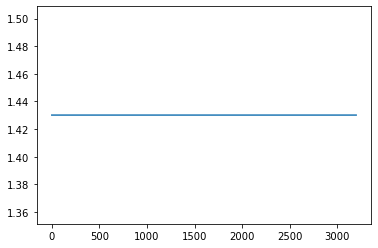

In [5]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [11]:
stan_post_samples = loop_stan(sim_data)


Gradient evaluation took 0.010659 seconds
1000 transitions using 10 leapfrog steps per transition would take 106.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.019448 seconds
1000 transitions using 10 leapfrog steps per transition would take 194.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.020213 seconds
1000 transitions using 10 leapfrog steps per transition would take 202.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.018655 seconds
1000 transitions using 10 leapfrog steps per transition would take 186.55 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Boundary separation is inf, but must be finite!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Boundary separation is inf, but must be finite!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be reject

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Random variable  = 0.677548, but must be greater than nondecision time = 0.772137  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration:  800 / 2000 [ 40%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Random variable  = 0.194548, but must be greater than nondecision time = 0.210627  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 228.517 seconds (Warm-up)
               227.266 seconds (Sampling)
               455.783 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Boundary separation is 0, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Boundary separation is inf, but must be finite!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected be

Iteration:  200 / 2000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Random variable  = 0.115042, but must be greater than nondecision time = 0.118801  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Random variable  = 0.324042, but must be greater than nondecision time = 0.627473  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Random variable  = 0.123042, but must be greater than nondecision time = 0.13189  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Random variable  = 0.107042, but must be greater than nondecision time = 0.110048  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration:    1 / 2000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Boundary separation is inf, but must be finite!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: wiener_lpdf: Random variable  = 0.324042, but must be greater than nondecision time = 4.78778e+180  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Met

Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 182.493 seconds (Warm-up)
               131.395 seconds (Sampling)
               313.888 seconds (Total)

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 198.696 seconds (Warm-up)
               192.941 seconds (Sampling)
               391.637 seconds (Total)

Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elap

In [ ]:
# pickle.dump(
# {
#     'rt': sim_data[:, : , 0], 
#     'context': sim_data[:, : , 1], 
#     'theta_d': theta_d,
#     'stan_post_samples': stan_post_samples
#     }, 
#     open('sim_data_ablation/sim_data_ablation_3200_noVar.pkl', 'wb+')
# )

## Low variance

In [ ]:
prior_draws = dynamic_prior(BATCH_SIZE, fixed_var=0.001)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)
sim_data.shape

In [ ]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [ ]:
stan_post_samples = loop_stan(sim_data)

In [ ]:
# pickle.dump(
# {
#     'rt': sim_data[:, : , 0], 
#     'context': sim_data[:, : , 1], 
#     'theta_d': theta_d,
#     'theta_s': theta_s,
#     'stan_post_samples': stan_post_samples
#     }, 
#     open('sim_data_ablation/sim_data_ablation_3200_lowVar.pkl', 'wb+')
# )

## High variance

In [ ]:
prior_draws = dynamic_prior(BATCH_SIZE, fixed_var=0.1)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)
sim_data.shape

In [ ]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [ ]:
stan_post_samples = loop_stan(sim_data)

In [ ]:
# pickle.dump(
# {
#     'rt': sim_data[:, : , 0], 
#     'context': sim_data[:, : , 1], 
#     'theta_d': theta_d,
#     'theta_s': theta_s,
#     'stan_post_samples': stan_post_samples
#     }, 
#     open('sim_data_ablation/sim_data_ablation_3200_highVar.pkl', 'wb+')
# )

# Amortizers

## Network architecture

In [8]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d, n_params_s):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        self.static_predictor = Sequential([
            LSTM(n_params_s),
            Dense(tfpl.MultivariateNormalTriL.params_size(n_params_s)),
            tfpl.MultivariateNormalTriL(n_params_s)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        # predict static
        preds_stat = self.static_predictor(rep)

        return preds_dyn, preds_stat

class StaticHeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d):
        super(StaticHeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        
    def call(self, x):
        """
        Forward pass through the model.
        """
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        return preds_dyn

## Loss

In [9]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

## Epoch helper

In [10]:
def epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar, fixed_var):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            # Simulate from model
            prior_draws = dynamic_prior(batch_size, fixed_var)
            context = context_gen(batch_size, n_obs)
            sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)

            # predict
            net_in = tf.concat((sim_data[:, :, :1], to_categorical(sim_data[:, :, 1:])), axis=-1)
            pred_theta_d, pred_theta_s = network(net_in)

            # loss
            loss_d = nll(theta_d, pred_theta_d)
            loss_s = nll(theta_s, pred_theta_s)
            total_loss = loss_d + loss_s

        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)

def static_epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar):
    
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
        
            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            context = context_gen(batch_size, n_obs)
            sim_data, theta_d = static_batch_simulator(prior_draws, context)

            net_in = tf.concat((sim_data[:, :, :1], to_categorical(sim_data[:, :, 1:])), axis=-1)
            pred_theta_d = network(net_in)

            # Loss 
            loss_d = nll(theta_d, pred_theta_d)
            
            total_loss = loss_d
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)
            
            total_loss = loss_d
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)

## Training

In [11]:
N_OBS = 3200
BATCH_SIZE = 8
STEPS_PER_EPOCH = 1000
epochs = [50, 25, 25]
learning_rates = [0.0001, 0.00005, 0.00001]

### No variance (static)

In [ ]:
network = StaticHeteroscedasticNetwork(6)

In [ ]:
%%time
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            static_epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar)
    
    #save weights
    network.save_weights('checkpoints/ablation_static_3200')

### Low variance

In [ ]:
network = HeteroscedasticNetwork(6, 6)

In [ ]:
%%time
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar, 0.001)
    
    #save weights
    network.save_weights('checkpoints/ablation_lowVar_3200')

### High variance

In [ ]:
network = HeteroscedasticNetwork(6, 6)

In [ ]:
%%time
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar, 0.1)
    
    #save weights
    network.save_weights('checkpoints/ablation_highVar_3200')

# Evaluation

In [12]:
# load trained network
network_no_var   = StaticHeteroscedasticNetwork(6)
network_low_var  = HeteroscedasticNetwork(6, 6)
network_high_var = HeteroscedasticNetwork(6, 6)
network_no_var.load_weights('checkpoints_ablation/ablation_noVar_3200')
network_low_var.load_weights('checkpoints_ablation/ablation_lowVar_3200')
network_high_var.load_weights('checkpoints_ablation/ablation_highVar_3200')

In [ ]:
# color palette (from bright to dark)
'#d36666', '#852626', '#5d1b1b'

In [13]:
def plot_post_sd(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, res, types):
    # get mean and sd of posterior sd's from Bayesflow fits
    bf_post_no_var_sd   = np.array(bf_post_no_var.stddev()).mean(axis=0)
    bf_post_low_var_sd  = np.array(bf_post_low_var.stddev()).mean(axis=0)
    bf_post_high_var_sd = np.array(bf_post_high_var.stddev()).mean(axis=0)
    bf_post_no_var_sd_sd   = np.array(bf_post_no_var.stddev()).std(axis=0)
    bf_post_low_var_sd_sd  = np.array(bf_post_low_var.stddev()).std(axis=0)
    bf_post_high_var_sd_sd = np.array(bf_post_high_var.stddev()).std(axis=0)

    # get mean and sd posterior sd's from Stan fits
    stan_sd = np.zeros((100, 6))
    for j in range(100):
        v = stan_post_samples[j]['v']
        a = stan_post_samples[j]['a']
        ndt = stan_post_samples[j]['ndt']

        stan_posterior = np.c_[v, a, ndt]
        stan_sd[j] = stan_posterior.std(axis=0)

    stan_sd_sd = stan_sd.std(axis=0)
    stan_sd = stan_sd.mean(axis=0)

    # plotting info
    labels = ['No variance', 'Low variance', 'High variance', "Static Stan"]
    param_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
    colors = ['#D18186', '#7697CA', '#4f8752', "#000000"]
    param_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']
    alpha = 0.8
    linewidth = 3

    # plotting time window
    x_min = int(bf_post_no_var_sd.shape[0] - res)
    time = np.arange(x_min, bf_post_no_var_sd.shape[0])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)

    # iterate over parameters
    for i, ax in enumerate(axarr.flat):
        # plot Bayesflow results
        ax.plot(time, bf_post_no_var_sd[x_min:, i], color=colors[0], label=labels[0], alpha=alpha, linewidth=linewidth)
        ax.plot(time, bf_post_low_var_sd[x_min:, i], color=colors[1], label=labels[1], alpha=alpha, linewidth=linewidth)
        ax.plot(time, bf_post_high_var_sd[x_min:, i], color=colors[2], label=labels[2], alpha=alpha, linewidth=linewidth)
        ax.fill_between(time, bf_post_no_var_sd[x_min:, i]+bf_post_no_var_sd_sd[x_min:, i]/2, bf_post_no_var_sd[x_min:, i]-bf_post_no_var_sd_sd[x_min:, i]/2, color=colors[0], alpha=0.2)
        ax.fill_between(time, bf_post_low_var_sd[x_min:, i]+bf_post_low_var_sd_sd[x_min:, i]/2, bf_post_low_var_sd[x_min:, i]-bf_post_low_var_sd_sd[x_min:, i]/2, color=colors[1], alpha=0.2)
        ax.fill_between(time, bf_post_high_var_sd[x_min:, i]+bf_post_high_var_sd_sd[x_min:, i]/2, bf_post_high_var_sd[x_min:, i]-bf_post_high_var_sd_sd[x_min:, i]/2, color=colors[2], alpha=0.2)

        # plot Stan results
        ax.hlines(y=stan_sd[i], xmin=x_min, xmax=800, color=colors[3], label=labels[3], linestyles="dashed", linewidth=1.5)
        stan_sd_array = np.repeat(stan_sd[i], len(time))
        ax.fill_between(time, stan_sd_array+stan_sd_sd[i]/2, stan_sd_array-stan_sd_sd[i]/2, color=colors[3], alpha=0.2)

        # set appropriate x-axis limits
        max_val = np.array([bf_post_no_var_sd[x_min:, i], 
                            bf_post_low_var_sd[x_min:, i],
                            bf_post_high_var_sd[x_min:, i]]).max()
        ax.set_ylim(0, max_val + max_val/2)

        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Posterior standard deviation', fontsize=12)
        ax.set_title(param_labels[i] + ' ({})'.format(param_names[i]), fontsize=12)

        if i == 0:  
            ax.legend()
            f.suptitle("Parameter std's over time: {}".format(labels[types]) + " simulated data", fontsize=16)

    f.tight_layout()

In [14]:
def plot_post_mean_error(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, types):
    # get mean and sd of posterior means's from Bayesflow fits
    bf_post_mean_no_var      = np.array(bf_post_no_var.mean()).mean(axis=0)
    bf_post_mean_low_var     = np.array(bf_post_low_var.mean()).mean(axis=0)
    bf_post_mean_high_var    = np.array(bf_post_high_var.mean()).mean(axis=0)
    bf_post_mean_no_var_sd   = np.array(bf_post_no_var.mean()).std(axis=0)
    bf_post_mean_low_var_sd  = np.array(bf_post_low_var.mean()).std(axis=0)
    bf_post_mean_high_var_sd = np.array(bf_post_high_var.mean()).std(axis=0)

    # get mean and sd posterior mean's from Stan fits
    stan_mean = np.zeros((100, 6))
    for j in range(100):
        v = stan_post_samples[j]['v']
        a = stan_post_samples[j]['a']
        ndt = stan_post_samples[j]['ndt']

        stan_posterior = np.c_[v, a, ndt]
        stan_mean[j] = stan_posterior.mean(axis=0)

    stan_mean_sd = stan_mean.std(axis=0)
    stan_mean = stan_mean.mean(axis=0)

    sqrt_err_no_var = (bf_post_mean_no_var - stan_mean)**2
    sqrt_err_low_var = (bf_post_mean_low_var - stan_mean)**2
    sqrt_err_high_var = (bf_post_mean_high_var - stan_mean)**2

    # plotting info
    labels = ['No variance', 'Low variance', 'High variance']
    param_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
    colors = ['#D18186', '#7697CA', '#4f8752', "#000000"]
    param_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']
    alpha = 0.8
    linewidth = 3

    # plotting time window
    time = np.arange(sqrt_err_no_var.shape[0])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)

    # iterate over parameters
    for i, ax in enumerate(axarr.flat):
        # plot Bayesflow results
        ax.plot(time, sqrt_err_no_var[:, i], color=colors[0], label=labels[0], alpha=alpha, linewidth=linewidth)
        ax.plot(time, sqrt_err_low_var[:, i], color=colors[1], label=labels[1], alpha=alpha, linewidth=linewidth)
        ax.plot(time, sqrt_err_high_var[:, i], color=colors[2], label=labels[2], alpha=alpha, linewidth=linewidth)

        # set appropriate x-axis limits
        max_val = np.array([sqrt_err_no_var[:, i], 
                            sqrt_err_low_var[:, i],
                            sqrt_err_high_var[:, i]]).max()
        ax.set_ylim(0, max_val + max_val/2)

        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Squared Error of posterior mean', fontsize=12)
        ax.set_title(param_labels[i] + ' ({})'.format(param_names[i]), fontsize=12)

        if i == 0:  
            ax.legend()
            f.suptitle("Difference between posterior means of BayesFlow and Stan: 100 {}".format(labels[types]) + " simulated data", fontsize=16)

    f.tight_layout()

### No variance (static)

In [15]:
# load simulated data and stan fits
sim = pd.read_pickle('./sim_800_noVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
stan_post_samples = sim['stan_post_samples']

In [16]:
# amortized inference
bf_post_no_var   = network_no_var(sim_data)
bf_post_low_var  = network_low_var(sim_data)
bf_post_high_var = network_high_var(sim_data)

2022-02-17 14:30:56.491171: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_22281/1329004810.py:66: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


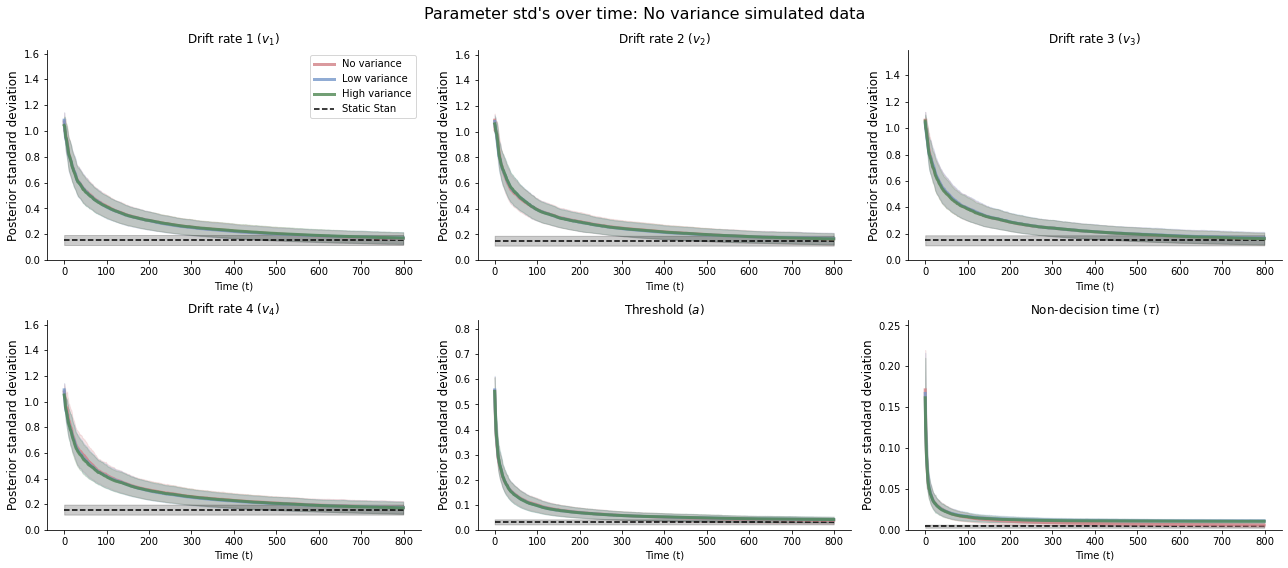

In [17]:
plot_post_sd(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 800, 0)

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_22281/3351216825.py:61: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


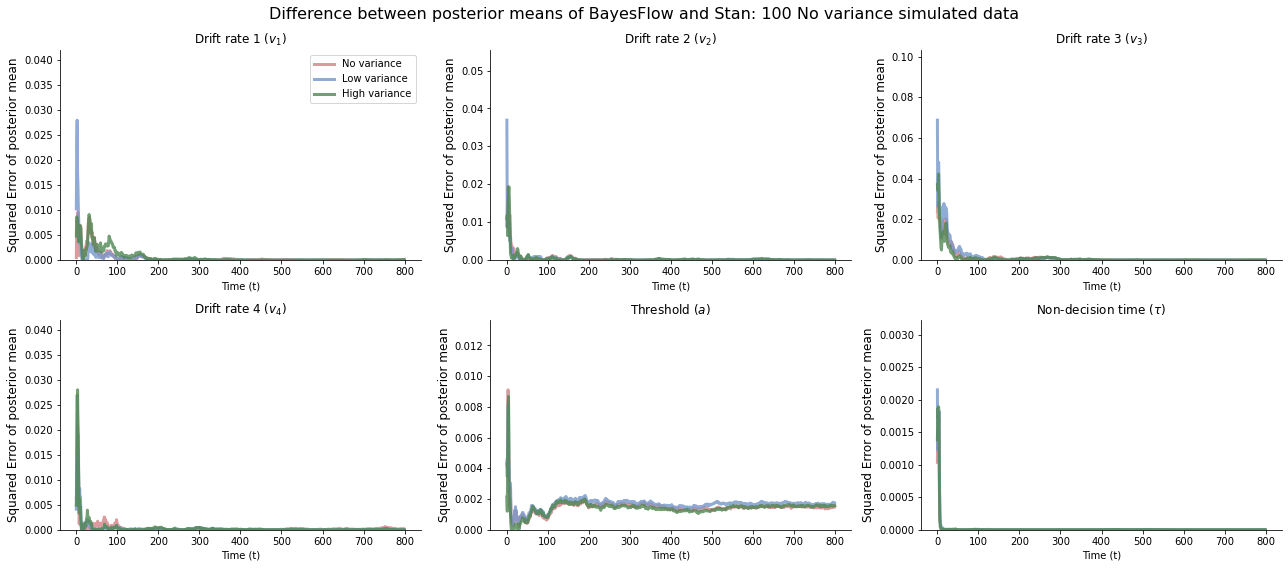

In [18]:
plot_post_mean_error(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 0)

### Low variance

In [19]:
# load simulated data and stan fits
sim = pd.read_pickle('./sim_800_lowVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
true_theta_d = sim['theta_d']
stan_post_samples = sim['stan_post_samples']

In [20]:
# amortized inference
bf_post_no_var   = network_no_var(sim_data)
bf_post_low_var  = network_low_var(sim_data)
bf_post_high_var = network_high_var(sim_data)

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_22281/1329004810.py:66: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


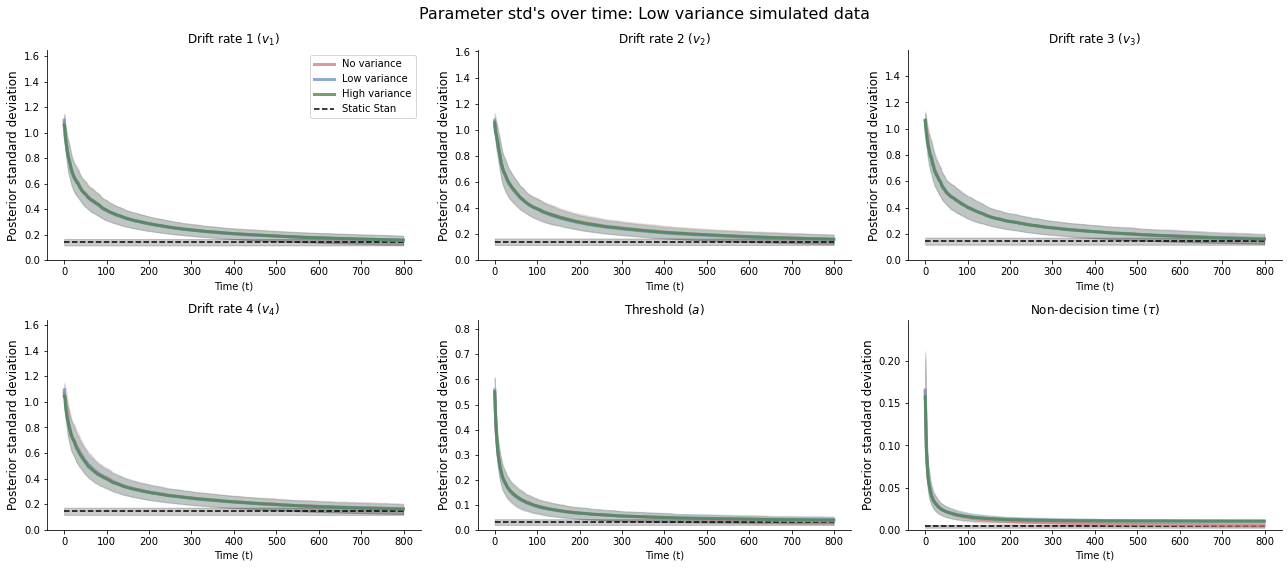

In [21]:
plot_post_sd(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 800, 1)

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_22281/3351216825.py:61: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


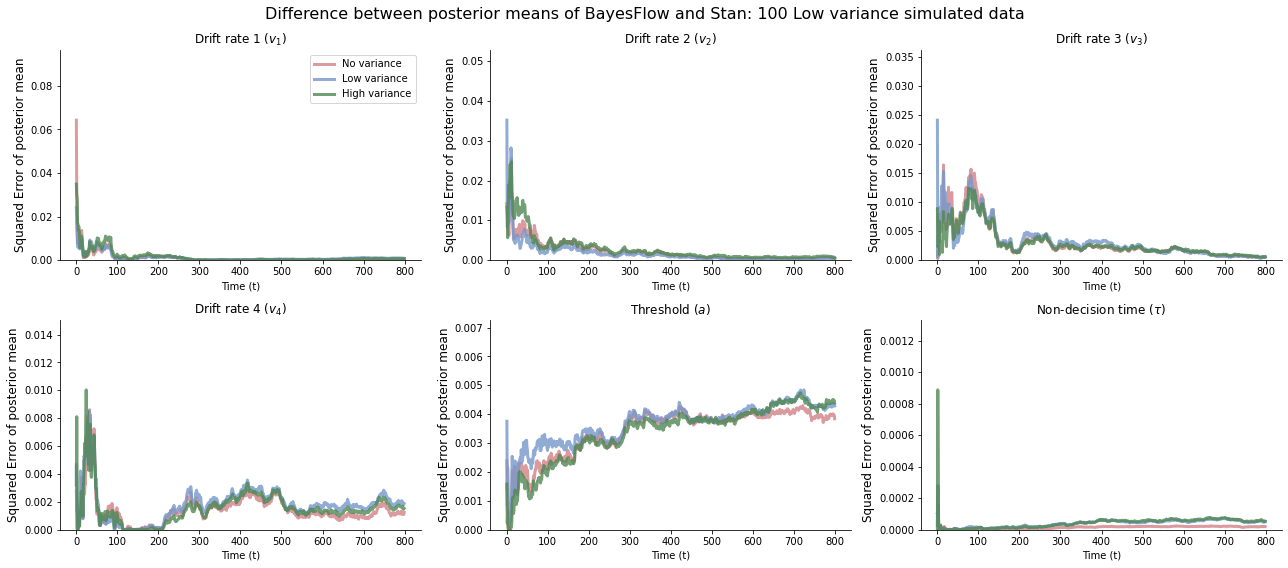

In [22]:
plot_post_mean_error(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 1)

### High variance

In [23]:
# load simulated data and stan fits
sim = pd.read_pickle('./sim_800_highVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
true_theta_d = sim['theta_d']
stan_post_samples = sim['stan_post_samples']

In [24]:
# amortized inference
bf_post_no_var   = network_no_var(sim_data)
bf_post_low_var  = network_low_var(sim_data)
bf_post_high_var = network_high_var(sim_data)

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_22281/1329004810.py:66: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


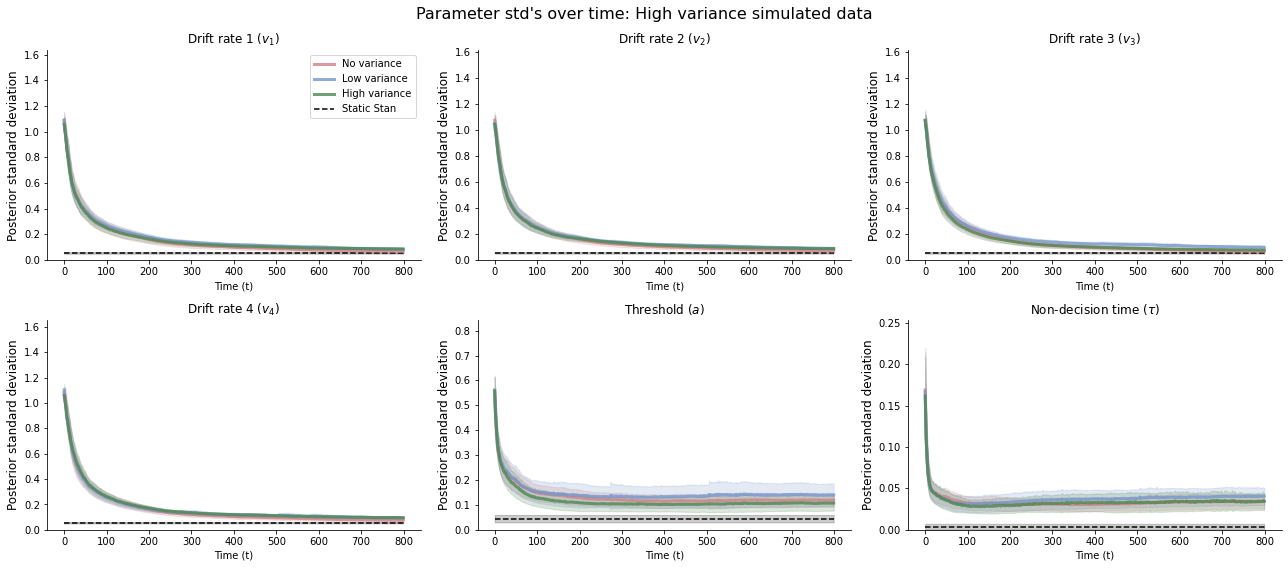

In [25]:
plot_post_sd(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 800, 2)

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_22281/3351216825.py:61: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


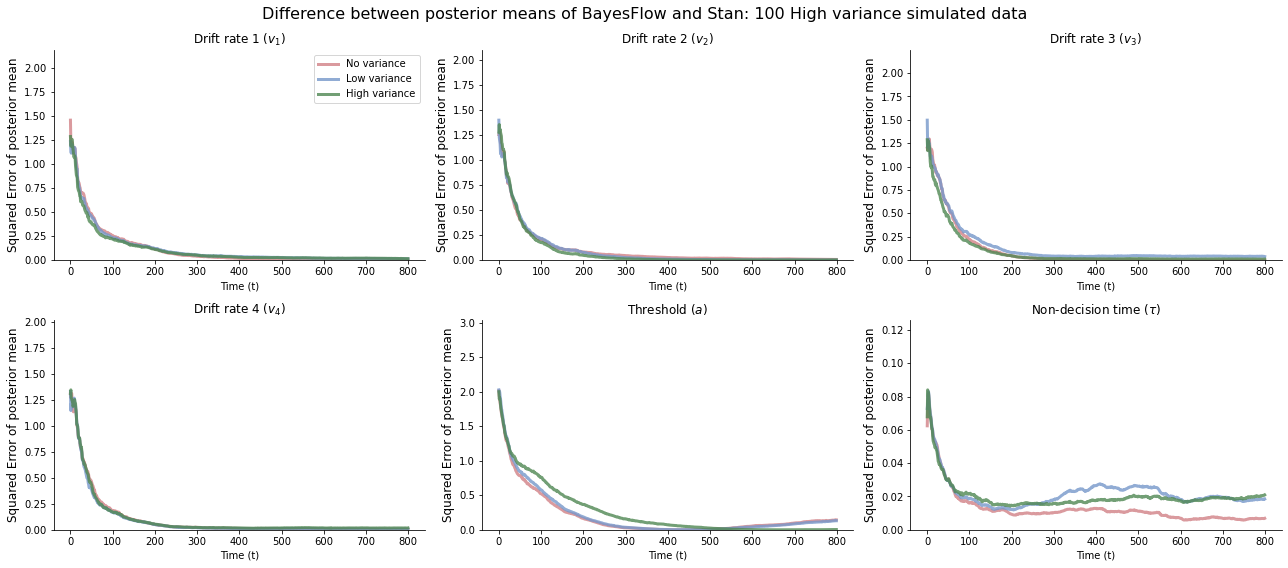

In [26]:
plot_post_mean_error(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 2)